<a href="https://colab.research.google.com/github/SuhyunL/projects/blob/main/Game_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'다음 분기에 어떤 게임을 설계해야 할까'

*   Sprint 1 : EDA, Feature Engineering, 
* Sprint 2 : Data Manipulation, Data Visualization
* Sprint 3 : DR, PCA, Cluster

# 0. 데이터 전처리

In [17]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from functools import reduce


#전체 value_counts()값을 확인해야 하는 columns를 위한 함수 정의
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv') 
#장르 총 13개
df.head(5) #총 df의 길이 16598, Unnamed:0이라는 의미없는 인덱스 열 있음.
df.dtypes #Year를 제외한 numerical values들의 데이터 타입이 object type. 변환 필요.

df['Platform'].unique() #총 31개의 플랫폼, 특이점 없음

#print_full(df.Year.value_counts())
len(df[(df["Year"] < 1980)])
#1980~2020년까지 value 확인됨, 허나 nan 및 년도가 아닌 숫자 발견됨.
#이같은 숫자값들의 숫자값은 100개, 전체 데이터셋의 0.6%정도만을 차지하므로 drop할 것임.


df['Genre'].isna().sum() #nan=50
df['Genre'].value_counts() 
#nan값 확인 이외 특이점 없음.
#다른 genre값들은 최소 500개 이상, 최대 몇천개 단위의 값인 점을 감안하면 drop해도 무방해 보임.

df['Publisher'].isna().sum() #nan=58
#print_full(df.Publisher.value_counts()) 
#해당 처리의 경우 다른 publisher중 1개만 퍼블리싱한 값이 다수이기에 nan drop이 어려움.
#Nan을 'Unknown Publisher'로 대체할 것.

df['NA_Sales'].unique() 
#결측치 존재, 이외에도 0.04,0.58M,220K 등 단위들이 어지럽게 섞여있어 매출액의 단위 통일이 필요

df.head(5)

"""
 데이터 프레임 정리에서 해야할 것:
 1) Unnamed:0이라는 행 drop
 2) Year에서 1980년보다 작은, 오류값 제거할 것
 3) Genre에서 nan값 drop할 것
 4) Publisher에서 nan값 'Unknown Publisher'로 대체할 것
 5) 매출액(NA_Sales, Eu_Sales, JP_Sales, Other_Sales)에서 단위 통일할 것, data type str -> float로 변환할 것.
"""

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [4]:
#'unnamed'행 정리
df = df.drop('Unnamed: 0',axis=1)

#1980보다 작은 오류값 지울 것
df = df[(df["Year"] >= 1980)]

#Publisher에서 nan값 'Unknown Publisher'로 대체할 것
df['Publisher'] = df['Publisher'].fillna('Unknown Publisher')

#매출액(NA_Sales, Eu_Sales, JP_Sales, Other_Sales)에서 단위 통일할 것.
def unitChanger(n):
  units = {"K":0.001,"M":1}
  try:
      float(n)
      return n
  except ValueError:
      unit=n[-1]
      n = float( n[:-1] )
      return n * units[unit]
  
df.NA_Sales = df.NA_Sales.apply(unitChanger)
df.EU_Sales = df.EU_Sales.apply(unitChanger)
df.JP_Sales = df.JP_Sales.apply(unitChanger)
df.Other_Sales = df.Other_Sales.apply(unitChanger)

#numerical values들의 data type str -> float
df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']] = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].apply(pd.to_numeric, errors='coerce')

#Genre에서 nan값 drop할 것
df['Genre'] = df['Genre'].dropna()

df.isna().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

# 1. 지역에 따라 선호하는 게임 장르가 다를까?

* 1) Two-Sample Chi-Square 

In [5]:
#쉬운 분석을 위해 Name등 무의미한 데이터를 제외한 데이터들로 tidy data 생성.

tidy = df.melt(id_vars = ['Genre','Platform','Year','Publisher'], value_vars = ['NA_Sales', 'JP_Sales','EU_Sales','Other_Sales'])
tidy = tidy.rename(
    columns = {
        'variable': 'Area', 
        'value': 'Sales'
        }
)
tidy.head(3)

,Genre,Platform,Year,Publisher,Area,Sales
0,Action,DS,2008.0,Destineer,NA_Sales,0.04
1,Action,Wii,2009.0,Namco Bandai Games,NA_Sales,0.17
2,Adventure,PSP,2010.0,Alchemist,NA_Sales,0.00


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


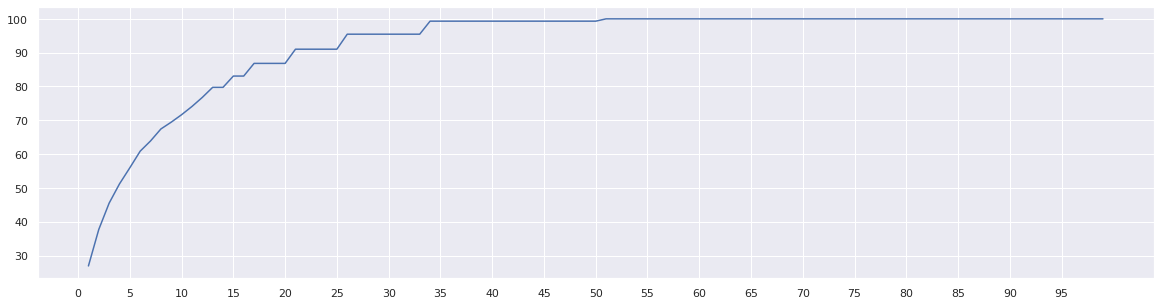

In [114]:
import matplotlib.pyplot as plt

all = []

for i in range(1,100):
  game_10 = tidy.sort_values('Sales', ascending=False)[0:(len(tidy)//(100//i))]['Sales'].sum()
  game_all = tidy.Sales.sum()
  ratio = game_10/game_all*100
  all.append(ratio)

sns.set(rc={'figure.figsize':(20,5)});
plt.xticks(np.arange(0,100,5));
x_axis = range(1,100);
sns.lineplot(x_axis,all);

#전체 게임의 반 이상은 매출이 아예 없는 것이나 마찬가지.
#상위 5%의 게임이 전체 매출의 50% 이상을 차지함,
#상위 10%의 게임은 전체 매출의 70% 이상을 차지.
#상위권의 일부 게임들이 전체 시장을 견인함.

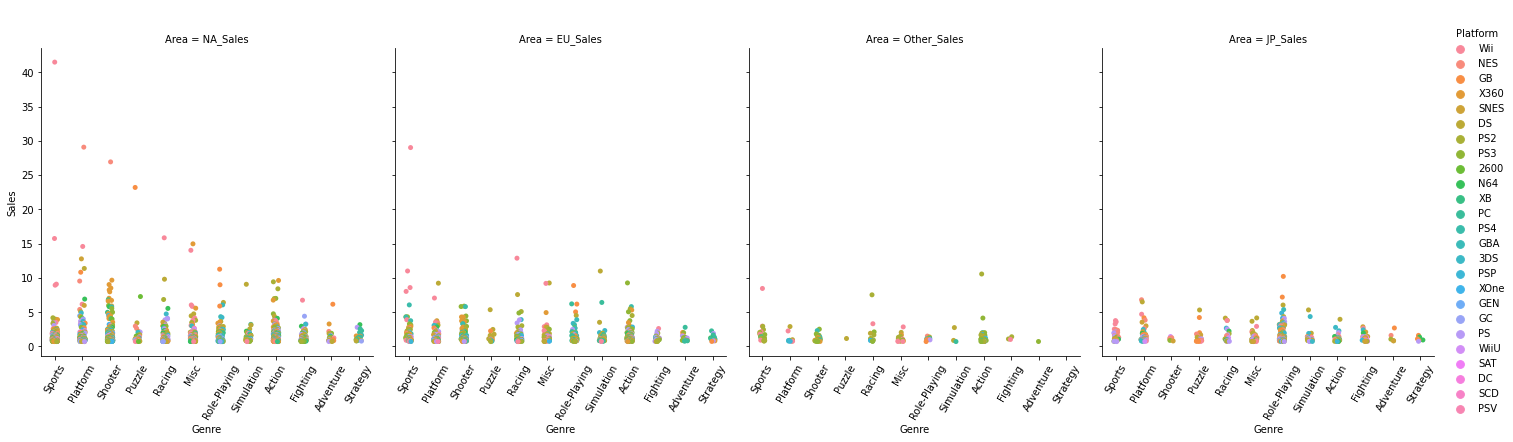

In [7]:
newdf = tidy.sort_values('Sales', ascending=False)[0:(len(tidy)//(100//4))]
g = sns.catplot(x="Genre", y="Sales", hue="Platform",
                col="Area", data=newdf)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)


In [ ]:
print("Two Sample Chi-Square Result between Genre and Area\n")

NA_Sales_cut = pd.cut(df["NA_Sales"], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.
data = pd.crosstab(df.Genre,NA_Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('North America\n','Chi-Square:',chi, 'P-Value:', pvalue) #p-value가 0.05보다 작음: 

EU_Sales_cut = pd.cut(df["EU_Sales"], 10).astype("category")
data = pd.crosstab(df.Genre,EU_Sales_cut) #장르와 EU value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('\nEurpoe\n', 'Chi-Square:',chi, 'P-Value:', pvalue)

JP_Sales_cut = pd.cut(df["JP_Sales"], 10).astype("category")
data = pd.crosstab(df.Genre,JP_Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('\nJapan\n', 'Chi-Square:',chi,'P-Value:', pvalue)

"""
 귀무가설: 각 지역(미국, 유럽, 일본)과 장르는 independent한 variables다.
 대안가설: 각 지역(미국, 유럽, 일본)과 장르는 dependent한 variables다.
 
 신뢰도 95%수준에서 Chi-Square test결과 North America와 Japan의 경우 귀무가설을 기각할 수 있을 정도의 p값이 나옴
 미국과 일본의 경우 장르는 Sales와 연관이 있다. 즉, 특별히 선호하는 게임 장르가 있을 것이다
 유럽의 경우 장르는 Sales와 연관이 있지 않다.
 이에, 지역에 따라 선호하는 게임 장르에 대한 탐구는 North America와 Japan만을 중심으로 탐구할 것이다.
"""

Two Sample Chi-Square Result between Genre and Area

North America
 Chi-Square: 180.39331031234835 P-Value: 2.808339118165449e-10

Eurpoe
 Chi-Square: 67.80152749137372 P-Value: 0.11517891970103072

Japan
 Chi-Square: 328.1355493344092 P-Value: 2.1972293553116667e-29


In [39]:
print("Two Sample Chi-Square Result between Genre and Area\n")

Whole_Sales_cut = pd.cut(newdf['Sales'], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.
data = pd.crosstab(newdf.Genre,Whole_Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Whole\n','Chi-Square:',chi, 'P-Value:', pvalue) #p-value가 0.05보다 작음: 

na_cut = newdf[(newdf.Area == 'NA_Sales')]
Sales_cut = pd.cut(na_cut['Sales'], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.
data = pd.crosstab(na_cut.Genre,Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('North America\n','Chi-Square:',chi, 'P-Value:', pvalue) #p-value가 0.05보다 작음: 

na_cut = newdf[(newdf.Area == 'EU_Sales')]
Sales_cut = pd.cut(na_cut['Sales'], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.
data = pd.crosstab(na_cut.Genre,Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Europe\n','Chi-Square:',chi, 'P-Value:', pvalue) #p-value가 0.05보다 작음: 

na_cut = newdf[(newdf.Area == 'JP_Sales')]
Sales_cut = pd.cut(na_cut['Sales'], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.
data = pd.crosstab(na_cut.Genre,Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Japan\n','Chi-Square:',chi, 'P-Value:', pvalue) #p-value가 0.05보다 작음: 

na_cut = newdf[(newdf.Area == 'Other_Sales')]
Sales_cut = pd.cut(na_cut['Sales'], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.
data = pd.crosstab(na_cut.Genre,Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Other Countries\n','Chi-Square:',chi, 'P-Value:', pvalue) #p-value가 0.05보다 작음: 

"""
 귀무가설: 각 지역(미국, 유럽, 일본)과 장르는 independent한 variables다.
 대안가설: 각 지역(미국, 유럽, 일본)과 장르는 dependent한 variables다.
 
 신뢰도 95%수준에서 Chi-Square test결과 전체적으로는 지역별 장르와 세일즈가 연관이 있는 것으로 나타났으나,
 이는 결국 North America에서만 국한된 것으로 나타남.
 북미 시장에서 '성공한 게임'의 장르는 Sales와 매우 dependent하다.
"""

Two Sample Chi-Square Result between Genre and Area

Whole
 Chi-Square: 90.53093948416577 P-Value: 0.024257407180847013
North America
 Chi-Square: 110.98431003325346 P-Value: 0.0004442698056613828
Europe
 Chi-Square: 45.65326666313098 P-Value: 0.8113213776819751
Japan
 Chi-Square: 52.34799682413561 P-Value: 0.985898946368858
Other Countries
 Chi-Square: 41.500152788388085 P-Value: 0.967096035089851


In [6]:
# 지역에 따라 선호하는 게임 장르가 다를까? 지역별 매출 장르에 대한 t-test.'
genres = df.Genre.unique()
from scipy import stats

print('[P-value by Genre]\n')
is_dif = []
n_dif = y_dif = []
for i in range(0,len(genres)-1):
  game = genres[i]
  t_df = df[(df.Genre == game)]
  t_test,p_value = stats.ttest_ind(t_df['NA_Sales'], t_df['JP_Sales'])
  print('<',genres[i],'>',p_value)
  if p_value < 0.05:
    is_dif.append(game)
  else:
    n_dif.append(game)

print('지역별로 선호도가 차이나는 장르는',is_dif)
print('지역별로 선호도가 차이나지 않는 장르는',n_dif)

[P-value by Genre]

< Action > 1.991458238553195e-92
< Adventure > 2.2609332234095965e-06
< Misc > 3.0661831290768677e-22
< Platform > 4.742631816937145e-11
< Sports > 1.1432054834936173e-24
< Simulation > 1.0278885014994013e-12
< Racing > 3.1137960099073967e-26
< Role-Playing > 0.39276192334604065
< Puzzle > 0.01643207137232437
< Strategy > 0.027718826028821118
< Fighting > 2.4607662690287113e-15
지역별로 선호도가 차이나는 장르는 ['Action', 'Adventure', 'Misc', 'Platform', 'Sports', 'Simulation', 'Racing', 'Puzzle', 'Strategy', 'Fighting']
지역별로 선호도가 차이나지 않는 장르는 ['Role-Playing']


In [9]:
# 인기 게임의 경우 지역에 따라 선호하는 게임 장르가 다를까? 지역별 매출 장르에 대한 t-test.'
genres = newdf.Genre.unique()
from scipy import stats

print('[P-value by Genre]\n')
is_dif = []
n_dif = y_dif = []
for i in range(0,len(genres)-1):
  game = genres[i]
  t_df = newdf[(newdf.Genre == game)]
  t_test,p_value = stats.ttest_ind(t_df[(t_df.Area == 'NA_Sales')]['Sales'], t_df[(t_df.Area == 'JP_Sales')]['Sales'])
  print('<',genres[i],'>',p_value)
  if p_value < 0.05:
    is_dif.append(game)
  else:
    n_dif.append(game)

print('지역별로 선호도가 차이나는 장르는',is_dif)
print('지역별로 선호도가 차이나지 않는 장르는',n_dif)

[P-value by Genre]

< Sports > 0.7787459255822193
< Platform > 0.19855751772884572
< Shooter > 0.31852136123043406
< Puzzle > 0.3290731668691045
< Racing > 0.7824760350220838
< Misc > 0.2322871289535277
< Role-Playing > 0.8936317434855924
< Simulation > 0.9443566579944207
< Action > 0.05039032146712151
< Fighting > 0.9319137783862849
< Adventure > 0.7849845605386522
지역별로 선호도가 차이나는 장르는 []
지역별로 선호도가 차이나지 않는 장르는 ['Sports', 'Platform', 'Shooter', 'Puzzle', 'Racing', 'Misc', 'Role-Playing', 'Simulation', 'Action', 'Fighting', 'Adventure']


In [10]:
tidy1 = tidy[((tidy['Area'] == 'NA_Sales') | (tidy['Area'] == 'JP_Sales'))]
newdf1 = newdf[((newdf['Area'] == 'NA_Sales') | (newdf['Area'] == 'JP_Sales'))]

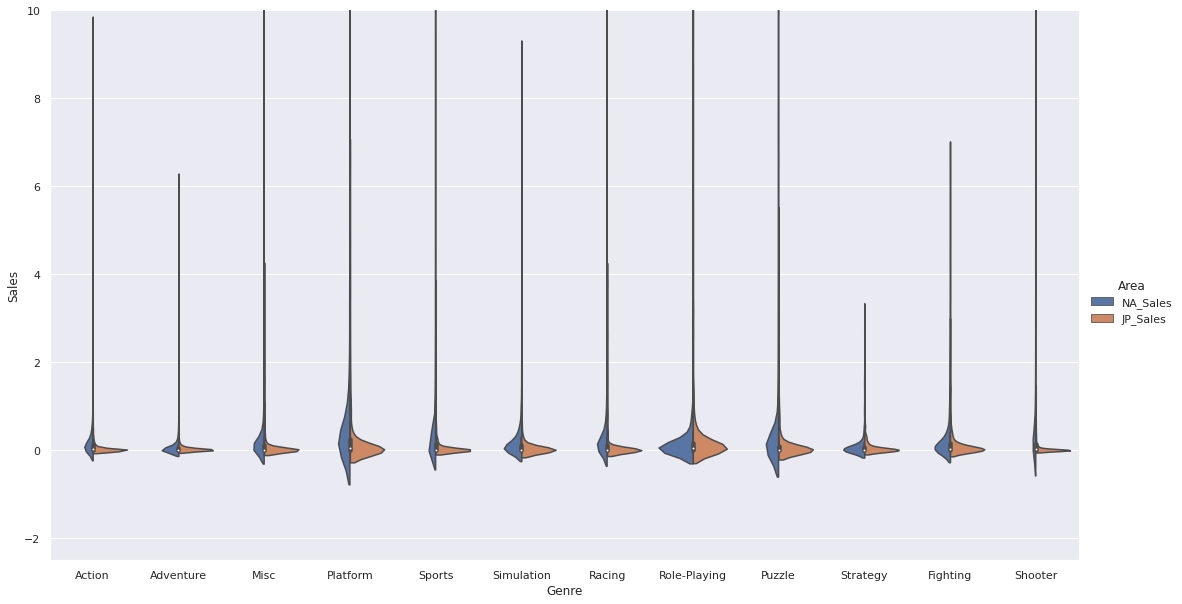

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.catplot(data=tidy1, kind='violin', x="Genre", y="Sales", hue="Area", split=True, height=8.27, aspect=15/8.27)
plt.ylim(-2.5,10);

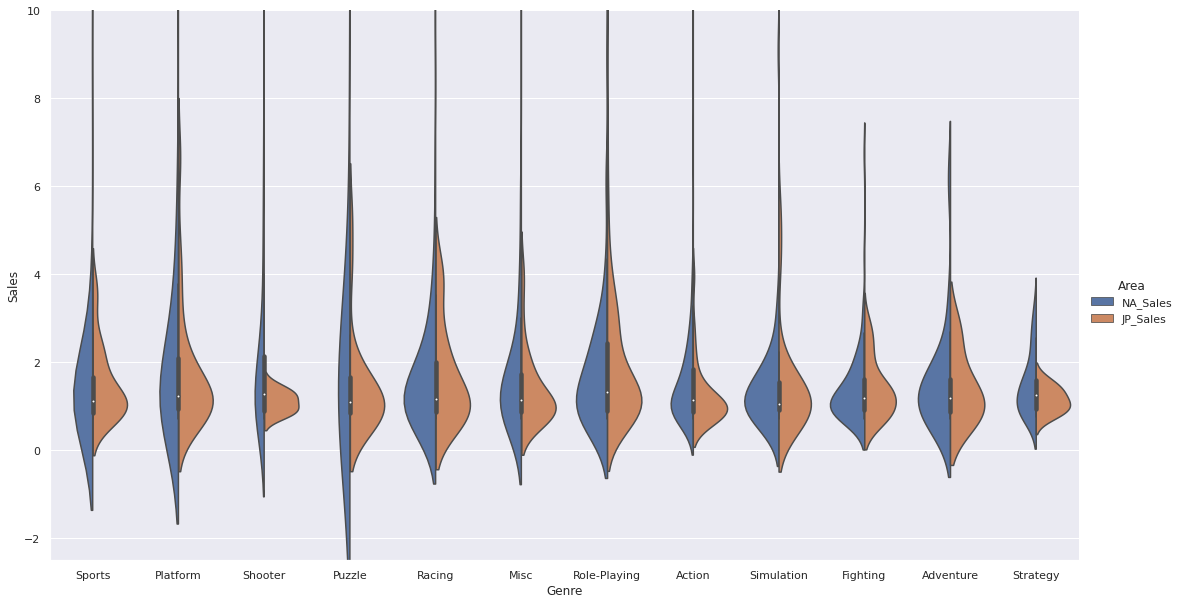

In [54]:
## 상위권 게임
newdf1 = newdf[((newdf['Area'] == 'NA_Sales') | (newdf['Area'] == 'JP_Sales'))]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.catplot(data=newdf1, kind='violin', x="Genre", y="Sales", hue="Area", split=True, height=8.27, aspect=15/8.27)
plt.ylim(-2.5,10);

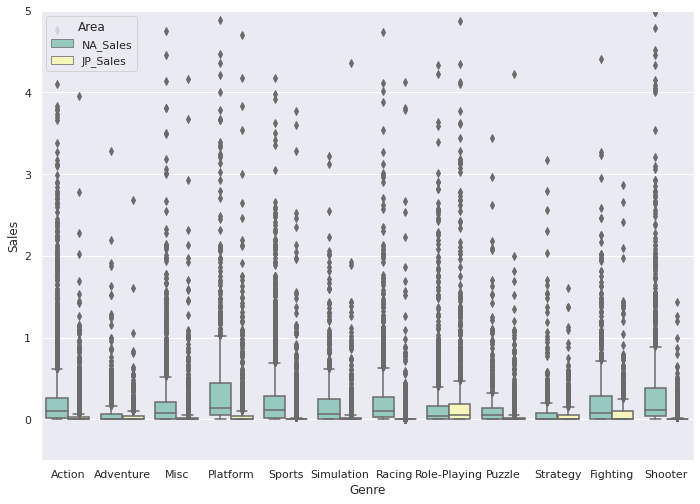

In [61]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
tidy1 = tidy[((tidy['Area'] == 'NA_Sales') | (tidy['Area'] == 'JP_Sales'))]
sns.boxplot(data=tidy1, x="Genre", y="Sales", palette = "Set3", hue="Area")
plt.ylim(-0.5,5);

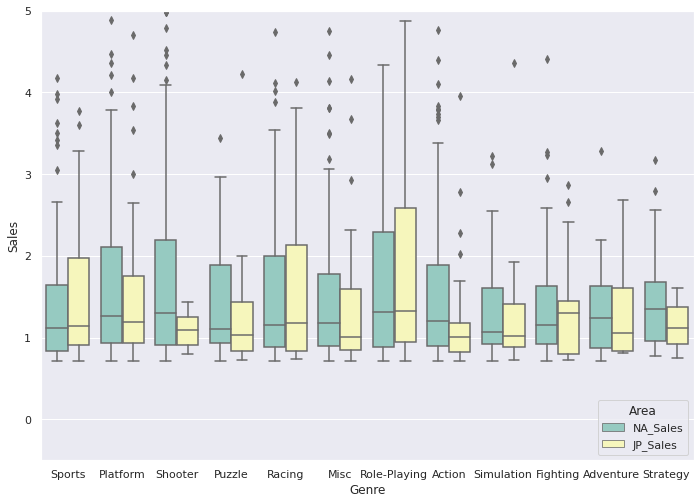

In [59]:
## 상위권 게임
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=newdf1, x="Genre", y="Sales", palette = "Set3", hue="Area")
plt.ylim(-0.5,5);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


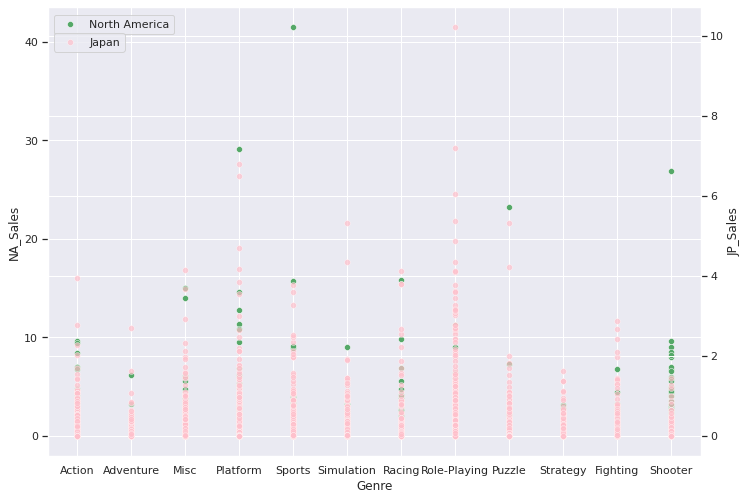

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(15,10)});
sns.scatterplot(df.Genre,df.NA_Sales, color="g",label='North America');

ax2 = plt.twinx();
sns.scatterplot(df.Genre,df.JP_Sales, color="pink", alpha = 0.7, ax=ax2,label='Japan');

ax.legend(loc=(0.01,0.94));
ax2.legend(loc=(0.01,0.90));

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


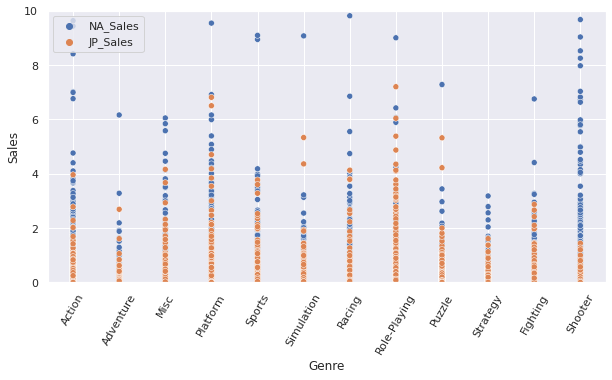

In [72]:
sns.scatterplot(tidy1.Genre,tidy1.Sales, hue=tidy1.Area)
plt.ylim(0,10)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(rotation=60)
plt.legend(loc="upper left");

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


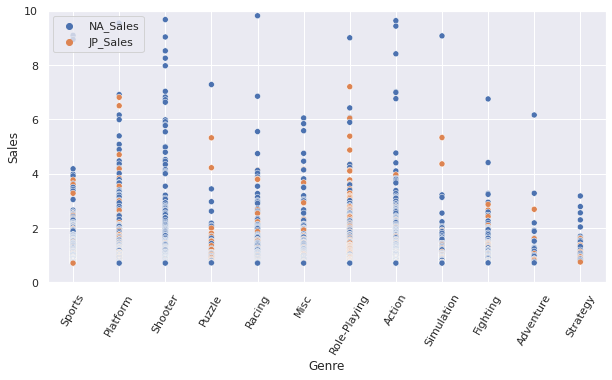

In [71]:
sns.scatterplot(newdf1.Genre,newdf1.Sales, hue=newdf1.Area)
plt.ylim(0,10)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(rotation=60)
plt.legend(loc="upper left");

In [80]:
# tidy = 전체 data tidy version
# tidy1 = NA Sales, JP Sales만 골라놓은 것
# newdf = 상위 25%데이터만 포함한 것
# newdf1 = 상위 25%데이터 중 NA Sales, JP Sales만 뽑아놓은 것

,Genre,Platform,Year,Area,Sales
2843,Sports,Wii,2006.0,NA_Sales,41.49
4095,Platform,NES,1985.0,NA_Sales,29.08
35197,Sports,Wii,2006.0,EU_Sales,29.02
10232,Shooter,NES,1984.0,NA_Sales,26.93
1181,Puzzle,GB,1989.0,NA_Sales,23.20
...,...,...,...,...,...
46651,Puzzle,PS2,2002.0,EU_Sales,0.71
14922,Role-Playing,3DS,2015.0,NA_Sales,0.71
8853,Role-Playing,GC,2005.0,NA_Sales,0.71
11114,Simulation,Wii,2008.0,NA_Sales,0.71


In [ ]:
#년도에 따라 더 많이 나온 게임이 있을까?
#년도와 Sales

print("Two Sample Chi-Square Result between Genre and Area\n")

NA_Sales_cut = pd.cut(df["NA_Sales"], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.
data = pd.crosstab(df.Year,NA_Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('North America\n','Chi-Square:',chi, 'P-Value:', pvalue) #p-value가 0.05보다 작음: 

EU_Sales_cut = pd.cut(df["EU_Sales"], 10).astype("category")
data = pd.crosstab(df.Year,EU_Sales_cut) #장르와 EU value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('\nEurpoe\n', 'Chi-Square:',chi, 'P-Value:', pvalue)

JP_Sales_cut = pd.cut(df["JP_Sales"], 10).astype("category")
data = pd.crosstab(df.Year,JP_Sales_cut) #장르와 북미 value간 관련성 확인을 위한 two-sample chi square test
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('\nJapan\n', 'Chi-Square:',chi,'P-Value:', pvalue)

"""
 귀무가설: 각 지역(미국, 유럽, 일본)과 장르는 independent한 variables다.
 대안가설: 각 지역(미국, 유럽, 일본)과 장르는 dependent한 variables다.
 
 신뢰도 95%수준에서 Chi-Square test결과 North America와 Japan의 경우 귀무가설을 기각할 수 있을 정도의 p값이 나옴
 미국과 일본의 경우 장르는 Sales와 연관이 있다. 즉, 특별히 선호하는 게임 장르가 있을 것이다
 유럽의 경우 장르는 Sales와 연관이 있지 않다.
 이에, 지역에 따라 선호하는 게임 장르에 대한 탐구는 North America와 Japan만을 중심으로 탐구할 것이다.
"""

Two Sample Chi-Square Result between Genre and Area

North America
 Chi-Square: 3678.438727535731 P-Value: 0.0

Eurpoe
 Chi-Square: 155.46789437389972 P-Value: 0.9683494397811694

Japan
 Chi-Square: 3062.6740646664375 P-Value: 0.0


In [ ]:
data = pd.crosstab(df.Year,df.Genre)
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print(pvalue)  # ==>년도별로 유난히 많이 나온 게임이 있다.

0.0


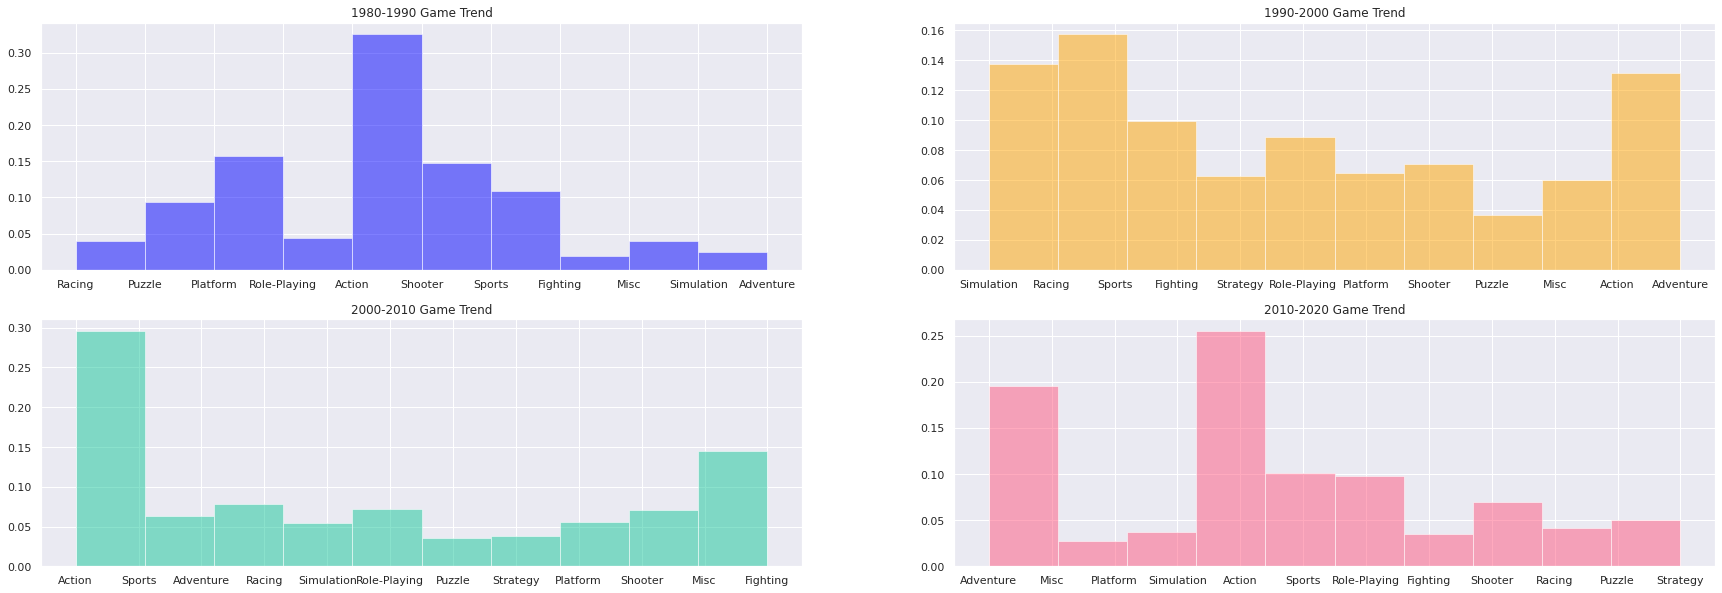

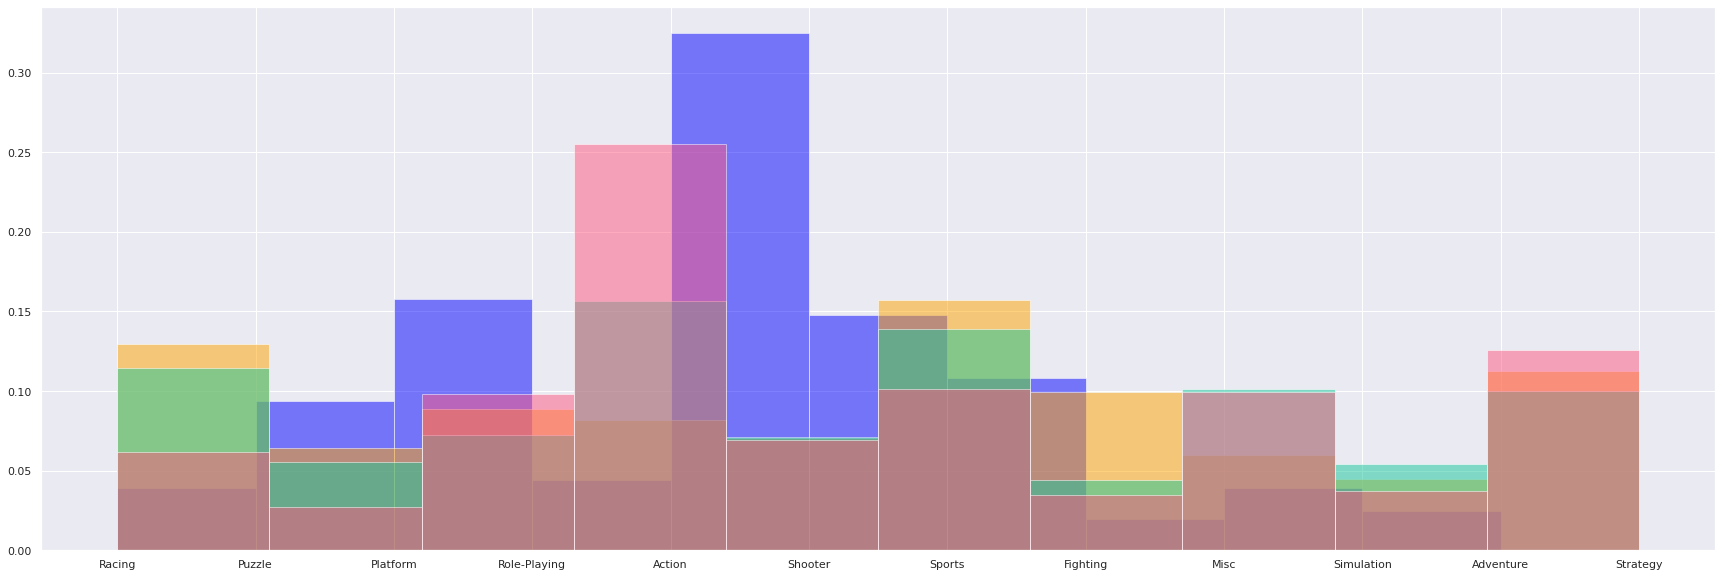

In [ ]:
plt.rcParams['figure.figsize'] = [30, 10]

fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)

data1 = df[((df.Year >= 1980) & (df.Year < 1990))]
data2 = df[((df.Year >= 1990) & (df.Year < 2000))]
data3 = df[((df.Year >= 2000) & (df.Year < 2010))]
data4 = df[((df.Year >= 2010) & (df.Year <= 2020))]

ax1.hist(data1.Genre, alpha=0.5, color = 'blue', density=True)
ax1.set_title('1980-1990 Game Trend')
ax2.hist(data2.Genre, alpha=0.5, color= 'orange', density=True)
ax2.set_title('1990-2000 Game Trend')
ax3.hist(data3.Genre, alpha=0.5, color= '#16c79a', density=True) #green
ax3.set_title('2000-2010 Game Trend')
ax4.hist(data4.Genre, alpha=0.5, color= '#ff577f', density=True) #pink
ax4.set_title('2010-2020 Game Trend')
plt.show();

fig,ax = plt.subplots()
plt.hist(data1.Genre, alpha=0.5, color = 'blue', density=True)
plt.hist(data2.Genre, alpha=0.5, color= 'orange', density=True)
plt.hist(data3.Genre, alpha=0.5, color= '#16c79a', density=True) #green
plt.hist(data4.Genre, alpha=0.5, color= '#ff577f', density=True) ;

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


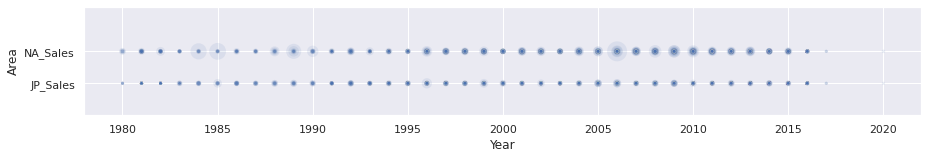

In [101]:
plt.rcParams['figure.figsize'] = [15, 2]
plt.ylim(-1.4,2)
sns.scatterplot(tidy1.Year, tidy1.Area, size = tidy1.Sales, sizes = (10,400), alpha=0.1, legend=False);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


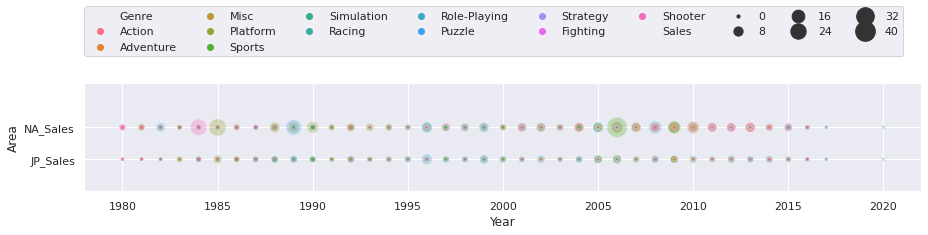

In [92]:
plt.rcParams['figure.figsize'] = [15, 2]
plt.ylim(-1.4,2)
sns.scatterplot(tidy1.Year, tidy1.Area, hue = tidy1.Genre, size = tidy1.Sales, sizes = (10,400), alpha=0.3);
plt.legend(loc = 2, bbox_to_anchor=(0, 1.7), ncol=9, borderaxespad=0.);

In [ ]:
#매출이 높은 게임에 대한 분석 및 시각화 프로세스
#
#베이지안 회귀 분석
#공분산으로 상관계수 확인할 수 있을 것
#매출. 장르. 등등 기준으로 나눈 다음 clustering.
#매출과 관련해서 가장 중요한. 가장 핵심적인 feature만 남길 수 있을 것.

In [ ]:
#수치적 요소들에 대한 공분산 분석.
df.corr()
#EU Sales와 NA Sales간 높은 corr
#EU Sales와 JP Sales도 아주 높진 않더라도.
#JP Sales와 NA Sales
#NA Sales와 Other_Sales #NA관련 전반적으로 높았다.
#JP Sales는 상대적으로 적은 영향.

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Year,1.000000,-0.093127,0.004430,-0.174074,0.040090
NA_Sales,-0.093127,1.000000,0.767921,0.448453,0.633502
EU_Sales,0.004430,0.767921,1.000000,0.431446,0.727111
JP_Sales,-0.174074,0.448453,0.431446,1.000000,0.284445
Other_Sales,0.040090,0.633502,0.727111,0.284445,1.000000


In [110]:
df1 = newdf.pivot_table(index = 'Year', columns = 'Area', values = 'Sales').reset_index().fillna(0)
df1.corr()

Area,Year,EU_Sales,JP_Sales,NA_Sales,Other_Sales
Area,,,,,
Year,1.000000,0.369252,0.337639,-0.355673,0.540128
EU_Sales,0.369252,1.000000,0.645728,0.323035,0.251673
JP_Sales,0.337639,0.645728,1.000000,0.279066,0.259937
NA_Sales,-0.355673,0.323035,0.279066,1.000000,-0.150688
Other_Sales,0.540128,0.251673,0.259937,-0.150688,1.000000


In [ ]:
# Categorical Data에 대한 Chi-Square test
# 어떤 Categorical Data가 Sales와 관련이 있는가?

#전체 게임의 경우
tidy_Sales_cut = pd.cut(tidy3["Sales"], 10).astype("category")
data = pd.crosstab(tidy3.Genre,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Genre & Sales p-value',pvalue)

data = pd.crosstab(tidy3.Publisher,tidy_Sales_cut) #so irrelevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Publiser & Sales p-value',pvalue)

data = pd.crosstab(tidy3.Platform,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Platform & Sales p-value',pvalue)

data = pd.crosstab(tidy3.Area,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Area & Sales p-value',pvalue)

"""
 전체 게임의 Sales와 관련이 있는 Feature는 Genre, Platform, Area.
 Publisher는 관련이 없다.
 그 중 순서로는 Platform, Area, Genre 순으로 관련이 있다. 
"""

Genre & Sales p-value 1.6485168505438103e-09
Publiser & Sales p-value 1.0
Platform & Sales p-value 2.3442504700343066e-69
Area & Sales p-value 7.603875748869408e-13


In [119]:
##인기 게임의 경우...
tidy_Sales_cut = pd.cut(newdf["Sales"], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.

data = pd.crosstab(newdf.Genre,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Genre & Sales p-value',pvalue)

data = pd.crosstab(newdf.Publisher,tidy_Sales_cut) #irrelevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Publiser & Sales p-value',pvalue)

data = pd.crosstab(newdf.Platform,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Platform & Sales p-value',pvalue)

data = pd.crosstab(newdf.Area,tidy_Sales_cut) #irrelevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Area & Sales p-value',pvalue)

"""
 Sales와 관련이 있는 Feature는 Genre, Platform.
 Publisher, Area 등은 관련이 없다.
 그 중 순서로는 Platform, Genre 순으로 관련이 있다.
 인기 게임일수록 게임 그 자체의 특성이 커짐! 인기게임 -> 괜찮으니까, 국제적으로 먹히고, 더 잘 나간다. 
"""


Genre & Sales p-value 0.024257407180847013
Publiser & Sales p-value 1.0
Platform & Sales p-value 0.009140821565058237
Area & Sales p-value 0.9157732374480365


In [85]:
## 최신 게임의 경우...
recentdf = tidy[(tidy.Year >= 2010)]

tidy_Sales_cut = pd.cut(recentdf["Sales"], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.

data = pd.crosstab(recentdf.Genre,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Genre & Sales p-value',pvalue)


data = pd.crosstab(recentdf.Platform,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Platform & Sales p-value',pvalue)

data = pd.crosstab(recentdf.Area,tidy_Sales_cut) #irrelevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Area & Sales p-value',pvalue)

"""
 최신 게임? 장르, 플랫폼에 영향을 받는다.
 그 중에서도 장르 -> 플랫폼 순.
"""


Genre & Sales p-value 1.3908390349095012e-15
Platform & Sales p-value 4.0554720548911026e-10
Area & Sales p-value 8.954489344012887e-27


In [87]:
##최신&인기 게임의 경우...
recentdf = newdf[(newdf.Year >= 2010)]

tidy_Sales_cut = pd.cut(recentdf["Sales"], 10).astype("category") #Sales를 약 10개 그룹으로 나누어 continuous data로 변환.

data = pd.crosstab(recentdf.Genre,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Genre & Sales p-value',pvalue)

data = pd.crosstab(recentdf.Platform,tidy_Sales_cut) #relevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Platform & Sales p-value',pvalue)

data = pd.crosstab(recentdf.Area,tidy_Sales_cut) #irrelevant
chi, pvalue, _, _ = stats.chi2_contingency(data, correction=False)
print('Area & Sales p-value',pvalue)

"""
 최신 인기 게임?관련 없다.
"""

Genre & Sales p-value 0.8492283076161119
Platform & Sales p-value 0.9052360096149095
Area & Sales p-value 0.6409290001254966


In [10]:
 #관련없는 Publisher는 drop하고, 관련 있는 feature중 categorical value인 Platform과 Genre, Area는 one-hot encoding해줌.

tidy = tidy.drop('Publisher', axis=1)
tidy

,Genre,Platform,Year,Area,Sales
0,Action,DS,2008.0,NA_Sales,0.04
1,Action,Wii,2009.0,NA_Sales,0.17
2,Adventure,PSP,2010.0,NA_Sales,0.00
3,Misc,DS,2010.0,NA_Sales,0.04
4,Platform,PS3,2010.0,NA_Sales,0.12
...,...,...,...,...,...
64703,Platform,GC,2006.0,Other_Sales,0.01
64704,Action,PSP,2005.0,Other_Sales,0.00
64705,Sports,PS3,2015.0,Other_Sales,0.13
64706,Action,PSV,2013.0,Other_Sales,0.03


In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

x = tidy[['Genre','Platform','Area']].values

le = LabelEncoder() #원핫 인코딩을 위해 string -> int 변환
x[:,0] = le.fit_transform(x[:,0])#인덱스0의 Genre 변경
x[:,1] = le.fit_transform(x[:,1])#인덱스1의 Platform 변경
x[:,2] = le.fit_transform(x[:,2])#인덱스1의 Area 변경

ohe = OneHotEncoder()
ohe = ohe.fit_transform(x).toarray()

x_df = pd.get_dummies(tidy[['Genre','Platform','Area']])

valdf = pd.concat([tidy[['Sales']], x_df], axis=1)
valdf

,Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,Platform_N64,Platform_NES,Platform_NG,Platform_PC,Platform_PCFX,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Area_EU_Sales,Area_JP_Sales,Area_NA_Sales,Area_Other_Sales
0,0.04,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.04,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64703,0.01,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
64704,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
64705,0.13,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
64706,0.03,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

x = tidy1[['Genre','Platform','Area']].values

le = LabelEncoder() #원핫 인코딩을 위해 string -> int 변환
x[:,0] = le.fit_transform(x[:,0])#인덱스0의 Genre 변경
x[:,1] = le.fit_transform(x[:,1])#인덱스1의 Platform 변경
x[:,2] = le.fit_transform(x[:,2])#인덱스1의 Area 변경

ohe = OneHotEncoder()
ohe = ohe.fit_transform(x).toarray()

x_df = pd.get_dummies(tidy1[['Genre','Platform','Area']])

valdf1 = pd.concat([tidy1[['Sales']], x_df], axis=1)
valdf1

,Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,Platform_N64,Platform_NES,Platform_NG,Platform_PC,Platform_PCFX,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Area_JP_Sales,Area_NA_Sales
0,0.04,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.04,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32349,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
32350,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
32351,0.03,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
32352,0.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


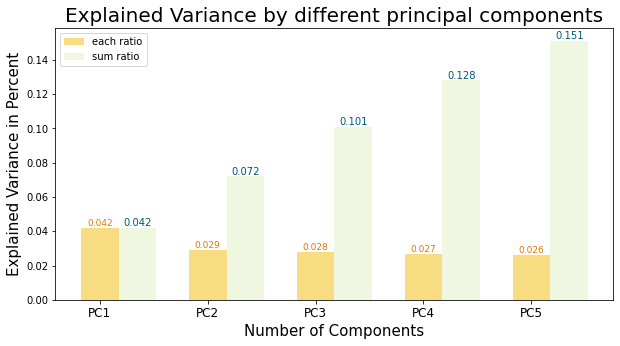

In [42]:
standardized = StandardScaler().fit_transform()
pca = PCA(n_components=5)
eig = pca.fit(standardized)
projD = pca.fit_transform(standardized)


pcaratio = pca.explained_variance_ratio_ #각 pc별 explained 정도(sum아님)


#PC갯수에 따른 결과를 sum ratio라는 리스트에 넣기 위한 함수
sumpcratio = []
for i in range(1,6): #적당히 큰 수를 설정. range는 1부터 시작.
  pca = PCA(n_components=i)
  printcipalComponents = pca.fit_transform(standardized)
  result = sum(pca.explained_variance_ratio_)
  sumpcratio.append(result);

#깔끔하게 보이기 위해 소수 셋째짜리까지만.
pcaratio = np.round(pcaratio,3)
sumpcratio = np.round(sumpcratio,3)


#시각화
fig = plt.figure(figsize=(10, 5)) #fig 사이즈설정
ax = fig.add_subplot() #ax 설정

bar_width = 0.35
alpha = 0.5

#dodge bar chart를 그릴 것이기에 레이블을 직접 설정.
table_label = ['PC1','PC2','PC3','PC4','PC5'] #레이블은 밑에 이름이 붙는 것
index = np.arange(len(table_label)) #인덱스는 x축에 각각이 표시되는 자리.
p1 = plt.bar(index, pcaratio, align='center', width = bar_width, color = '#f8dc81');
p2 = plt.bar(index+bar_width,sumpcratio, align='center', width = bar_width, color = '#eff7e1');

# annotation
for i in range(0,5):
    plt.text(i+bar_width, sumpcratio[i], sumpcratio[i],               # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='#00587a',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

for i in range(0,5):
    plt.text(i, pcaratio[i], pcaratio[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='#e27802',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')
    

#세부 설정

ax.set_title('Explained Variance by different principal components', fontsize = 20)
ax.set_xlabel('Number of Components', fontsize = 15)
ax.set_ylabel('Explained Variance in Percent', fontsize = 15)
legend = ['each ratio','sum ratio']
ax.legend(legend);
plt.xticks(index, table_label, fontsize=12);


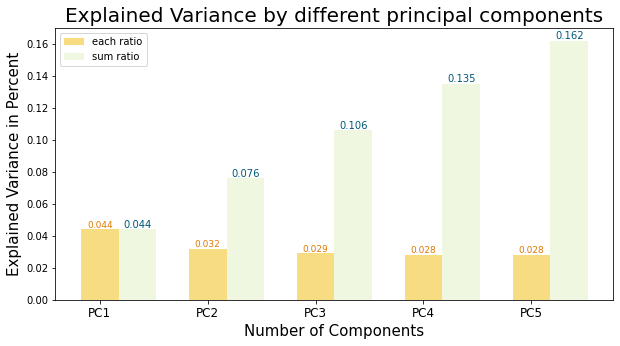

In [46]:
standardized = StandardScaler().fit_transform(valdf1)
pca = PCA(n_components=5)
eig = pca.fit(standardized)
projD = pca.fit_transform(standardized)


pcaratio = pca.explained_variance_ratio_ #각 pc별 explained 정도(sum아님)


#PC갯수에 따른 결과를 sum ratio라는 리스트에 넣기 위한 함수
sumpcratio = []
for i in range(1,6): #적당히 큰 수를 설정. range는 1부터 시작.
  pca = PCA(n_components=i)
  printcipalComponents = pca.fit_transform(standardized)
  result = sum(pca.explained_variance_ratio_)
  sumpcratio.append(result);

#깔끔하게 보이기 위해 소수 셋째짜리까지만.
pcaratio = np.round(pcaratio,3)
sumpcratio = np.round(sumpcratio,3)


#시각화
fig = plt.figure(figsize=(10, 5)) #fig 사이즈설정
ax = fig.add_subplot() #ax 설정

bar_width = 0.35
alpha = 0.5

#dodge bar chart를 그릴 것이기에 레이블을 직접 설정.
table_label = ['PC1','PC2','PC3','PC4','PC5'] #레이블은 밑에 이름이 붙는 것
index = np.arange(len(table_label)) #인덱스는 x축에 각각이 표시되는 자리.
p1 = plt.bar(index, pcaratio, align='center', width = bar_width, color = '#f8dc81');
p2 = plt.bar(index+bar_width,sumpcratio, align='center', width = bar_width, color = '#eff7e1');

# annotation
for i in range(0,5):
    plt.text(i+bar_width, sumpcratio[i], sumpcratio[i],               # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='#00587a',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

for i in range(0,5):
    plt.text(i, pcaratio[i], pcaratio[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='#e27802',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')
    

#세부 설정

ax.set_title('Explained Variance by different principal components', fontsize = 20)
ax.set_xlabel('Number of Components', fontsize = 15)
ax.set_ylabel('Explained Variance in Percent', fontsize = 15)
legend = ['each ratio','sum ratio']
ax.legend(legend);
plt.xticks(index, table_label, fontsize=12);


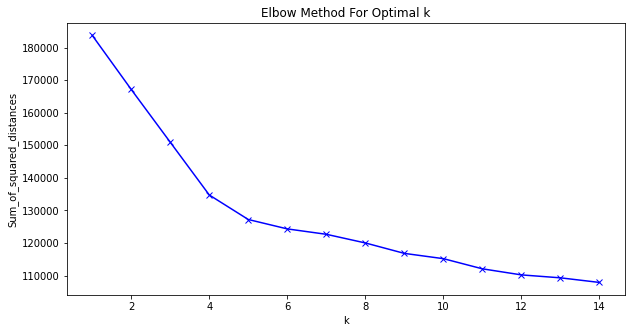

In [50]:
#Sales를 기준으로 Clustering 해볼 것임.

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler 


plt.rcParams["figure.figsize"] = (10,5)

sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(valdf)
    sum_of_squared_distances.append(km.inertia_) #Inertia value는 군집화가된 후에, 각 중심점에서 군집의 데이타간의 거리를 합산한 것, 즉 군집의 응집도를 나타내는 값

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#5개 정도 군집으로 Clustering하는 것이 적절해보임.

In [20]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(valdf) #year가 없는 군집을 clustering 함.
labels = kmeans.labels_
new_series = pd.Series(labels)
tidy['clusters'] = new_series.values
tidy

,Genre,Platform,Year,Area,Sales,clusters
0,Action,DS,2008.0,NA_Sales,0.04,2
1,Action,Wii,2009.0,NA_Sales,0.17,2
2,Adventure,PSP,2010.0,NA_Sales,0.00,2
3,Misc,DS,2010.0,NA_Sales,0.04,2
4,Platform,PS3,2010.0,NA_Sales,0.12,2
...,...,...,...,...,...,...
64703,Platform,GC,2006.0,Other_Sales,0.01,2
64704,Action,PSP,2005.0,Other_Sales,0.00,3
64705,Sports,PS3,2015.0,Other_Sales,0.13,0
64706,Action,PSV,2013.0,Other_Sales,0.03,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

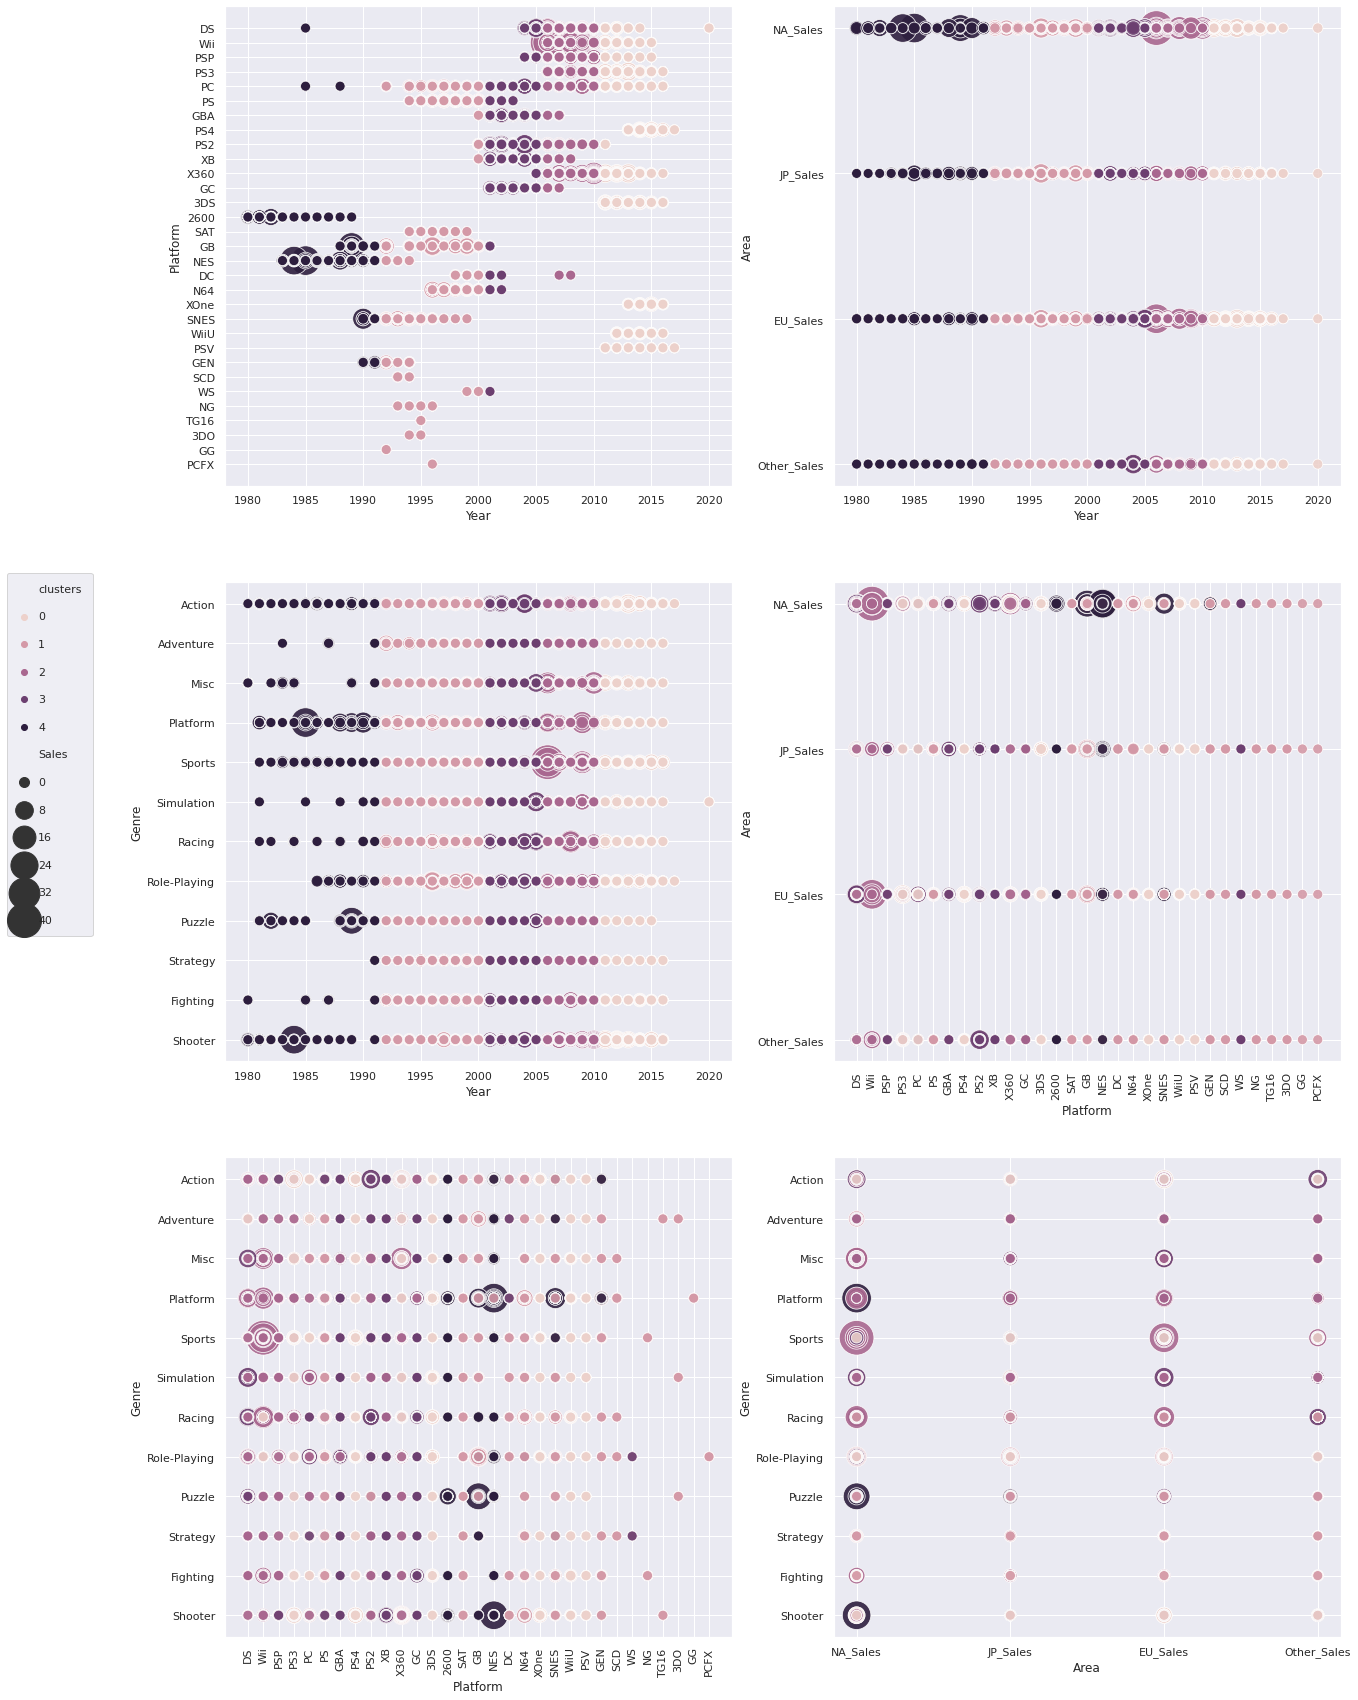

In [68]:
"""
 Sales와 관련이 있는 Feature는 Year, Genre, Platform, Area.
 Publisher는 관련이 없다.
 그 중 순서로는 Year, Platform, Area, Genre 순으로 관련이 있다. 
"""
plt.rcParams["figure.figsize"] = (20,30)
fig,((ax1, ax2),(ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2)
#sns.set_theme()

sns.scatterplot(tidy.Year, tidy.Platform, hue=tidy.clusters, size = tidy.Sales, sizes = (100,1200), alpha = 0.9, ax=ax1);
ax1.legend(bbox_to_anchor=(-0.25, -0.17), handlelength=1, labelspacing = 1.9, borderpad = 1);
#sns.set_theme()
#sns.despine(offset=10, trim=True);

sns.scatterplot(tidy.Year, tidy.Area, hue=tidy.clusters, size = tidy.Sales, alpha = 0.9, sizes = (100,1200), ax=ax2);
ax2.get_legend().remove();

sns.scatterplot(tidy.Year, tidy.Genre, hue=tidy.clusters, size = tidy.Sales, sizes = (100,1200), alpha = 0.9, ax=ax3);
ax3.get_legend().remove();

sns.scatterplot(tidy.Platform, tidy.Area, hue=tidy.clusters, size = tidy.Sales, sizes = (100,1200), alpha = 0.9, ax=ax4);
ax4.get_legend().remove();
ax4.tick_params('x',labelrotation=90);

sns.scatterplot(tidy.Platform, tidy.Genre, hue=tidy.clusters, size = tidy.Sales, sizes = (100,1200), alpha = 0.9, ax=ax5);
ax5.get_legend().remove();
ax5.tick_params('x',labelrotation=90);

sns.scatterplot(tidy.Area, tidy.Genre, hue=tidy.clusters, size = tidy.Sales, sizes = (100,1200), alpha = 0.9, ax=ax6);
ax6.get_legend().remove();


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

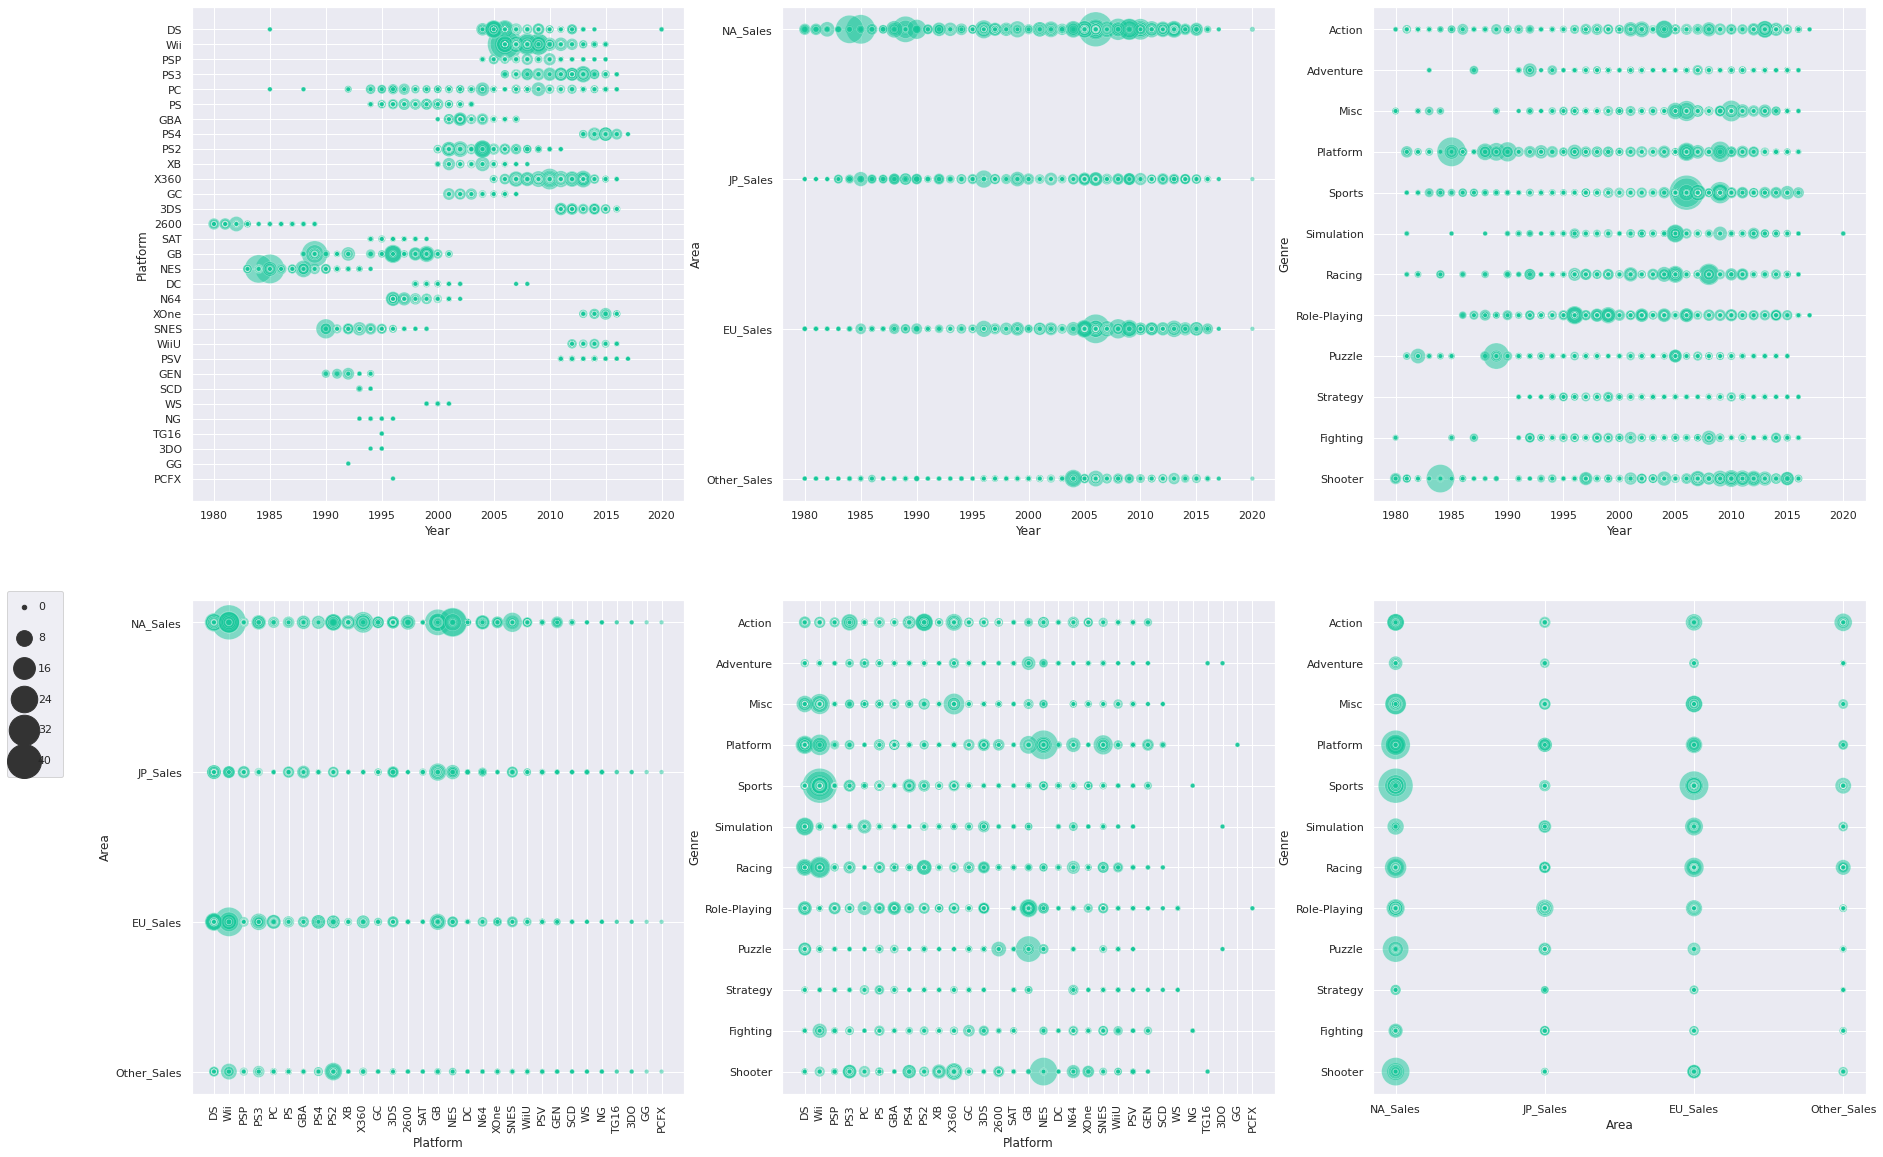

In [79]:
"""
 Sales와 관련이 있는 Feature는 Year, Genre, Platform, Area.
 Publisher는 관련이 없다.
 그 중 순서로는 Year, Platform, Area, Genre 순으로 관련이 있다. 
"""
plt.rcParams["figure.figsize"] = (30,20)
fig,((ax1, ax2,ax3),(ax4, ax5,ax6)) = plt.subplots(2, 3)
#sns.set_theme()

sns.scatterplot(x = tidy.Year, y = tidy.Platform, size = tidy.Sales, sizes = (20,1200), alpha = 0.5, ax=ax1, color = '#16c79a');
ax1.legend(bbox_to_anchor=(-0.25, -0.17), handlelength=1, labelspacing = 1.9, borderpad = 1);
#sns.set_theme()
#sns.despine(offset=10, trim=True);

sns.scatterplot(tidy.Year, tidy.Area, size = tidy.Sales, alpha = 0.5, sizes = (20,1200), ax=ax2, color = '#16c79a');
ax2.get_legend().remove();

sns.scatterplot(tidy.Year, tidy.Genre, size = tidy.Sales, sizes = (20,1200), alpha = 0.5, ax=ax3, color = '#16c79a');
ax3.get_legend().remove();

sns.scatterplot(tidy.Platform, tidy.Area, size = tidy.Sales, sizes = (20,1200), alpha = 0.5, ax=ax4, color = '#16c79a');
ax4.get_legend().remove();
ax4.tick_params('x',labelrotation=90);

sns.scatterplot(tidy.Platform, tidy.Genre, size = tidy.Sales, sizes = (20,1200), alpha = 0.5, ax=ax5, color = '#16c79a');
ax5.get_legend().remove();
ax5.tick_params('x',labelrotation=90);

sns.scatterplot(tidy.Area, tidy.Genre, size = tidy.Sales, sizes = (20,1200), alpha = 0.5, ax=ax6, color = '#16c79a');
ax6.get_legend().remove();


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

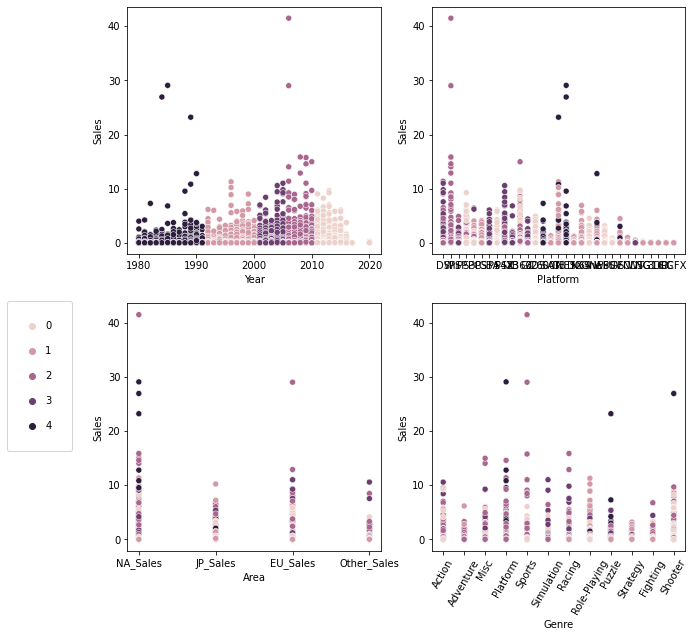

In [47]:
import matplotlib.pyplot as plt

"""
 Sales와 관련이 있는 Feature는 Year, Genre, Platform, Area.
 Publisher는 관련이 없다.
 그 중 순서로는 Year, Platform, Area, Genre 순으로 관련이 있다. 
"""
plt.rcParams["figure.figsize"] = (10,10)
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)

sns.scatterplot(tidy.Year,tidy.Sales, hue=tidy.clusters, ax=ax1);
ax1.legend(bbox_to_anchor=(-0.2, -0.17), handlelength=1, labelspacing = 1.5, borderpad = 2);

sns.scatterplot(tidy.Platform,tidy.Sales, hue=tidy.clusters, ax=ax2);
ax2.get_legend().remove();

sns.scatterplot(tidy.Area,tidy.Sales, hue=tidy.clusters, ax=ax3);
ax3.get_legend().remove();

sns.scatterplot(tidy.Genre,tidy.Sales, hue=tidy.clusters, ax=ax4);
ax4.get_legend().remove();
ax4.tick_params('x',labelrotation=60);

# sns.scatterplot(tidy3.Platform,tidy3.Genre, hue=tidy3.clusters, size = tidy3.Sales, sizes = (10,400), ax=ax5);
# ax5.get_legend().remove();
# ax5.tick_params('x',labelrotation=60);

# sns.scatterplot(tidy3.Area,tidy3.Genre, hue=tidy3.clusters, size = tidy3.Sales, sizes = (10,400), ax=ax6);
# ax6.get_legend().remove();


In [33]:
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

area = tidy.Area.values
genre = tidy.Genre.values
platform = tidy.Platform.values

standardized = StandardScaler().fit_transform(valdf) #클러스터 안 된 애들임.
pca = PCA(n_components=2)
eig = pca.fit(standardized)
projD = pca.fit_transform(standardized)
projD_df = pd.DataFrame(data = projD, columns = ['pc1', 'pc2'])
finaldf = projD_df
projD_df

,pc1,pc2
0,-0.592779,1.857125
1,0.940024,1.684528
2,-1.032644,1.126555
3,-1.431946,2.488892
4,1.459502,1.668284
...,...,...
64703,0.593154,-0.433589
64704,-0.849439,-0.975284
64705,0.884248,-0.933068
64706,-0.655117,-1.006632


In [ ]:
# Retro 게임이 강세인지는 확인X
# 예나 지금이나 강세는 NA. 북미에서는 어떤 게임? Sports (스포츠의 경우 유럽에서도 Sales 기대해볼 수 있음) (Platform, Puzzle, Shooter 또한 북미시장 나쁘지 않지만 다른 시장 공략에 취약해보임.)
# 최근에 나온 게임 중에서도 Sports
# 스포츠 게임의 경우 가장 좋은 플랫폼은 Wii. 위가 압도적.
# 스포츠 게임 중 2006년 출시작인 '~'가 압도적인 성공을 거둔 바 있어 이를 확인해보면 좋을 것.

In [ ]:
북미 시장에서 스포츠 게임의 성공 가능성.
베이지안.
전체 게임을 세일즈에 따라 1,2,3,4,5로 등급으로 나누고. (25%)


스포츠 게임B인데 인기 게임A이었을 확률 = 인기 게임A인데 스포츠 게임B이었을 확률 * 인기 A 게임이 될 확률 / 스포츠 게임일 확률 (인기 없는 게임 중 스포츠 게임일 확률+인기 있는 게임 중 스포츠 게임일 확률)

#인기 게임B인데 스포츠 게임A이었을 확률 = 스포츠 게임A인데 인기 게임B일 확률 * 스포츠 게임의 확률A / 인기 게임의 확률 - 스포츠 게임인데 인기 게임일 확률* 스포츠 게임이 아닌데 인기 게임일 확률.

In [97]:
na_all = tidy[(tidy.Area == 'NA_Sales')]

sports = na_all[(na_all.Genre == 'Sports')] #스포츠 게임의 확률
#스포츠 게임인데 인기 게임이었을 확률
na_pop = na_all.sort_values('Sales', ascending=False)[0:(len(tidy)//(100//4)-1)]
na_pop_sports = 
na_not_pop = na_all.sort_values('Sales', ascending=False)[(len(tidy)//(100//4)):]

,Genre,Platform,Year,Area,Sales,clusters
0,Action,DS,2008.0,NA_Sales,0.04,2
1,Action,Wii,2009.0,NA_Sales,0.17,2
2,Adventure,PSP,2010.0,NA_Sales,0.00,2
3,Misc,DS,2010.0,NA_Sales,0.04,2
4,Platform,PS3,2010.0,NA_Sales,0.12,2
...,...,...,...,...,...,...
64703,Platform,GC,2006.0,Other_Sales,0.01,2
64704,Action,PSP,2005.0,Other_Sales,0.00,3
64705,Sports,PS3,2015.0,Other_Sales,0.13,0
64706,Action,PSV,2013.0,Other_Sales,0.03,0


In [166]:
na_pop[(na_pop.Genre == 'Sports')]

,Genre,Platform,Year,Area,Sales,clusters
2843,Sports,Wii,2006.0,NA_Sales,41.49,2
3273,Sports,Wii,2009.0,NA_Sales,15.75,2
10630,Sports,Wii,2009.0,NA_Sales,9.09,2
3353,Sports,Wii,2007.0,NA_Sales,8.94,2
16170,Sports,PS2,2004.0,NA_Sales,4.18,3
...,...,...,...,...,...,...
15625,Sports,XB,2003.0,NA_Sales,0.24,3
9382,Sports,PSP,2006.0,NA_Sales,0.24,2
7220,Sports,PS,2001.0,NA_Sales,0.24,3
8399,Sports,2600,1981.0,NA_Sales,0.24,4


In [270]:
na_all = tidy[((tidy.Area == 'NA_Sales') & (tidy.Year >= 2010))]
na_pop = na_all.sort_values('Sales', ascending=False)[0:(len(na_all)//(100//25)-1)]
na_not_pop = na_all.sort_values('Sales', ascending=False)[(len(na_all)//(100//25)):]

#pop = 0.25 #인기 게임일 확률. 상위 25%므로 25%.

def bayes(genre):
  global pop, posterior_probability
  pop_ratio = len(na_pop[(na_pop.Genre == genre)]) / len(na_pop)
  not_pop_ratio = len(na_not_pop[(na_not_pop.Genre == genre)])

  for i in range(1,3):
    if i == 1:
      pop = 0.25
      not_pop = 1 - pop
      all = pop_ratio*pop + not_pop_ratio*not_pop
      posterior_probability = pop_ratio*pop / all
      print(i,'번 출시했을 때', genre,'게임이 인기 게임일 가능성은', posterior_probability)
      pop = posterior_probability
    
    else:
      posterior_probability = pop_ratio*pop / all
      print(i,'번 출시했을 때', genre,'게임이 인기 게임일 가능성은', posterior_probability)
      pop = posterior_probability
      # posterior_probability = pop_ratio*pop/ all
      # pop = posterior_probability

#genre_group = tidy.Genre.unique()

# for i in genre_group:
#   bayes(i)
bayes('Sports')
bayes('Platform')
bayes('Shooter')

1 번 출시했을 때 Sports 게임이 인기 게임일 가능성은 0.0001278152862959336
2 번 출시했을 때 Sports 게임이 인기 게임일 가능성은 6.534698964364589e-08
1 번 출시했을 때 Platform 게임이 인기 게임일 가능성은 0.00017261766051284707
2 번 출시했을 때 Platform 게임이 인기 게임일 가능성은 1.1918742688371408e-07
1 번 출시했을 때 Shooter 게임이 인기 게임일 가능성은 0.00024115216572698992
2 번 출시했을 때 Shooter 게임이 인기 게임일 가능성은 2.3261746813927048e-07


In [289]:
#특정 장르의 게임이 주어졌을 때 상위 25%안에 해당하는 인기 게임이 될 확률

na_all = tidy[((tidy.Area == 'NA_Sales') & (tidy.Year >= 2010))]
na_pop = na_all.sort_values('Sales', ascending=False)[0:(len(na_all)//(100//25)-1)]
na_not_pop = na_all.sort_values('Sales', ascending=False)[(len(na_all)//(100//25)):]


def bayes(Prob,genre):
  TPR = len(na_pop[(na_pop.Genre == genre)]) / len(na_pop) #인기 있는 게임 중 특정 장르의 게임인 확률
  FPR = len(na_not_pop[(na_not_pop.Genre == genre)]) / len(na_not_pop) #인기 게임이 아닌 상황에서 특정 장르의 게임일 확률
  p_not_used = 1 - Prob
  numerator = TPR*Prob
  denominator = numerator + (FPR*p_not_used)
  posterior_probability = numerator / denominator
  return posterior_probability


print('Sports-1:',bayes(0.25, 'Sports'))
print('Sports-2:',bayes(bayes(0.25, 'Sports'), 'Sports'),'\n')
print('Platform:',bayes(0.25, 'Platform'))
print('Platform-2:',bayes(bayes(0.25, 'Platform'), 'Platform'),'\n')
print('Shooter:',bayes(0.25, 'Shooter'))
print('Shooter-2:',bayes(bayes(0.25, 'Shooter'), 'Shooter'),'\n')

Sports-1: 0.32833080136989146
Sports-2: 0.4175409302907395 

Platform: 0.3976643459180649
Platform-2: 0.566650751497885 

Shooter: 0.479813734403779
Shooter-2: 0.7185002184880587 



In [284]:
#특정 장르의 게임이 주어졌을 때 상위 3%안에 해당하는 인기 게임이 될 확률

na_all = tidy[((tidy.Area == 'NA_Sales') & (tidy.Year >= 2010))]
na_pop = na_all.sort_values('Sales', ascending=False)[0:(len(na_all)//(100//3)-1)]
na_not_pop = na_all.sort_values('Sales', ascending=False)[(len(na_all)//(100//3)):]


def bayes(Prob,genre):
  TPR = len(na_pop[(na_pop.Genre == genre)]) / len(na_pop) #인기 있는 게임 중 특정 장르의 게임인 확률
  FPR = len(na_not_pop[(na_not_pop.Genre == genre)]) / len(na_not_pop) #인기 게임이 아닌 상황에서 특정 장르의 게임인 확률
  p_not_used = 1 - Prob
  numerator = TPR*Prob
  denominator = numerator + (FPR*p_not_used)
  posterior_probability = numerator / denominator
  return posterior_probability
  
print('Sports-1:',bayes(0.03, 'Sports'))
print('Sports-2:',bayes(bayes(0.03, 'Sports'), 'Sports'),'\n')
print('Platform:',bayes(0.03, 'Platform'))
print('Platform-2:',bayes(bayes(0.03, 'Platform'), 'Platform'),'\n')
print('Shooter:',bayes(0.03, 'Shooter'))
print('Shooter-2:',bayes(bayes(0.03, 'Shooter'), 'Shooter'),'\n')

Sports-1: 0.04935424699584472
Sports-2: 0.0801628350385033 

Platform: 0.05956865737579822
Platform-2: 0.1148307570770095 

Shooter: 0.10020236287498713
Shooter-2: 0.2862111120269463 



In [15]:
#특정 플랫폼을 이용한 게임이 상위 25%안에 해당하는 인기 게임이 될 확률

na_all = tidy[((tidy.Area == 'NA_Sales') & (tidy.Year >= 2010))]
na_pop = na_all.sort_values('Sales', ascending=False)[0:(len(na_all)//(100//3)-1)]
na_not_pop = na_all.sort_values('Sales', ascending=False)[(len(na_all)//(100//3)):]


def bayes(Prob,platform):
  TPR = len(na_pop[(na_pop.Platform == platform)]) / len(na_pop) #인기 있는 게임 중 특정 장르의 게임인 확률
  FPR = len(na_not_pop[(na_not_pop.Platform == platform)]) / len(na_not_pop) #인기 게임이 아닌 상황에서 특정 장르의 게임인 확률
  p_not_used = 1 - Prob
  numerator = TPR*Prob
  denominator = numerator + (FPR*p_not_used)
  posterior_probability = numerator / denominator
  return posterior_probability

platform_group = na_all.Platform.unique()

for i in platform_group:
  platform = i
  print(platform,'의 인기 게임이 될 확률은',bayes(0.25,platform))

PSP 의 인기 게임이 될 확률은 0.0
DS 의 인기 게임이 될 확률은 0.0408355427806824
PS3 의 인기 게임이 될 확률은 0.282516368784286
PC 의 인기 게임이 될 확률은 0.08650124004356555
PS4 의 인기 게임이 될 확률은 0.3536338398401352
X360 의 인기 게임이 될 확률은 0.46698781524511196
3DS 의 인기 게임이 될 확률은 0.18172795941997028
Wii 의 인기 게임이 될 확률은 0.2851704447136183
XOne 의 인기 게임이 될 확률은 0.4842785777255363
WiiU 의 인기 게임이 될 확률은 0.32052902849363024
PSV 의 인기 게임이 될 확률은 0.0
PS2 의 인기 게임이 될 확률은 0.0


In [14]:
#특정 플랫폼을 이용한 게임이 상위 25%안에 해당하는 인기 게임이 될 확률

na_all = tidy[((tidy.Genre == 'Shooter') & (tidy.Area == 'NA_Sales') & (tidy.Year >= 2010))]
na_pop = na_all.sort_values('Sales', ascending=False)[0:(len(na_all)//(100//25)-1)]
na_not_pop = na_all.sort_values('Sales', ascending=False)[(len(na_all)//(100//25)):]


def bayes(Prob,platform):
  TPR = len(na_pop[(na_pop.Platform == platform)]) / len(na_pop) #인기 있는 게임 중 특정 장르의 게임인 확률
  FPR = len(na_not_pop[(na_not_pop.Platform == platform)]) / len(na_not_pop) #인기 게임이 아닌 상황에서 특정 장르의 게임인 확률
  p_not_used = 1 - Prob
  numerator = TPR*Prob
  denominator = numerator + (FPR*p_not_used)
  posterior_probability = numerator / denominator
  return posterior_probability

platform_group = na_all.Platform.unique()

print('PS3','의 인기 게임이 될 확률은',bayes(0.25,'PS3'))
print('PS4','의 인기 게임이 될 확률은',bayes(0.25,'PS4'))
print('X360','의 인기 게임이 될 확률은',bayes(0.25,'X360'))
print('XOne','의 인기 게임이 될 확률은',bayes(0.25,'XOne'))
print('Wii','의 인기 게임이 될 확률은',bayes(0.25,'Wii'))
print('WiiU','의 인기 게임이 될 확률은',bayes(0.25,'WiiU'))

PS3 의 인기 게임이 될 확률은 0.22983669685516653
PS4 의 인기 게임이 될 확률은 0.42845205765615213
X360 의 인기 게임이 될 확률은 0.3467455621301775
XOne 의 인기 게임이 될 확률은 0.5194493690687245
Wii 의 인기 게임이 될 확률은 0.11282248748556026
WiiU 의 인기 게임이 될 확률은 0.10155979202772963


In [296]:
platform_group = na_all.Platform.unique()
platform_group

for i in platform_group:
  platform = i
  print(platform)#bayes(0.25,platform)

PSP
DS
PS3
PC
PS4
X360
3DS
Wii
XOne
WiiU
PSV
PS2


In [147]:
platform_group = tidy.Platform.unique()

for i in platform_group:
  platform = i
  print(platform)

DS
Wii
PSP
PS3
PC
PS
GBA
PS4
PS2
XB
X360
GC
3DS
2600
SAT
GB
NES
DC
N64
XOne
SNES
WiiU
PSV
GEN
SCD
WS
NG
TG16
3DO
GG
PCFX


In [139]:
for i in range(0,30):
  platform = platform_group[i]
  print(platform)

DS
Wii
PSP
PS3
PC
PS
GBA
PS4
PS2
XB
X360
GC
3DS
2600
SAT
GB
NES
DC
N64
XOne
SNES
WiiU
PSV
GEN
SCD
WS
NG
TG16
3DO
GG


In [106]:
def bayes(genre):
  global pop, posterior_probability
  all_ratio = len(na_all[(na_all.Genre == genre)]) / len(na_all)
  pop_ratio = len(na_pop[(na_pop.Genre == genre)]) / len(na_pop) #인기 있는 게임 중 스포츠 게임인 비율
  not_pop_ratio = len(na_not_pop[(na_not_pop.Genre == genre)]) / len(na_not_pop) #인기 없는 게임 중 스포츠 게임의 비율

bayes('Sports')
pop_ratio

0.16814843448009278

In [93]:
tidy2 = tidy[(tidy.Area == 'NA_Sales')]
tidy2

,Genre,Platform,Year,Area,Sales,clusters
0,Action,DS,2008.0,NA_Sales,0.04,2
1,Action,Wii,2009.0,NA_Sales,0.17,2
2,Adventure,PSP,2010.0,NA_Sales,0.00,2
3,Misc,DS,2010.0,NA_Sales,0.04,2
4,Platform,PS3,2010.0,NA_Sales,0.12,2
...,...,...,...,...,...,...
16172,Platform,GC,2006.0,NA_Sales,0.15,2
16173,Action,PSP,2005.0,NA_Sales,0.01,3
16174,Sports,PS3,2015.0,NA_Sales,0.44,0
16175,Action,PSV,2013.0,NA_Sales,0.05,0
